In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
#import plotly.express as px

#Tiesiog daugiau biblioteku instaliuojama.

In [51]:
#prisijungimas prie mySQL, ir kursoriaus sukūrimas
DB = cnt.connect(
host = '88.223.121.130',
user='user',
password='slaptazodis',
port=3306,
database='works'
)
C=DB.cursor()

In [17]:
#Turite nusiskaityti iš SQL DB lentelės autopliuslt į Pandas DataFrame gamintoją,
# kainą, pagaminimo datą, ridą, pavarų tipą, variklio informaciją. 
# SQL užklausoje turite atmesti tuos įrašus, kur rida nenurodyta, 
# taip pat palikite tik nesikartojančius įrašus (atranka pagal ID stuleplį - 
# jei ID sutampa - reiškia, jog skelbimas dubliuojasi)
sql="""with T1
as (select *, row_number() over (partition by id) as rc from autopliuslt)
select gamintojas, rida, price as kaina,
pagaminimo_data as data,
pavaros, variklis
from T1
where rc = 1 and rida != 'Nenurodyta' order by gamintojas"""
df = pd.read_sql_query(sql, con=DB)

df['R'] = df['rida'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['amžius'] = df['data'].apply(lambda s: 2024-int(s[:4]))

df.head()

,gamintojas,rida,kaina,data,pavaros,variklis,R,K,amžius
0,Alfa Romeo,305 000 km,2 100,2007-01,Mechaninė,"1910 cm³, 150 AG (110kW)",305000.0,2100.0,17
1,Alfa Romeo,308 615 km,4 900,2006-04,Mechaninė,"2387 cm³, 200 AG (147kW)",308615.0,4900.0,18
2,Aston Martin,45 000 km,125 000,2015-10,Automatinė,"5935 cm³, 517 AG (380kW)",45000.0,125000.0,9
3,Audi,112 000 km,25 000,2016-06,Automatinė,"3000 cm³, 333 AG (245kW)",112000.0,25000.0,8
4,Audi,450 000 km,7 800,2001-12,Automatinė,"4200 cm³, 360 AG (265kW)",450000.0,7800.0,23


In [5]:
#sql užklausa per pandas sql_query
#sql užklausa per pandas sql_query. Pridetas stulpelis su ridos intervalais 5000
sql="""with T1
as (select *, row_number() over (partition by id) as rc from autopliuslt)
select gamintojas, rida, price as kaina,
pagaminimo_data as data,
pavaros, variklis
from T1
where rc = 1 and rida != 'Nenurodyta' order by gamintojas"""
df = pd.read_sql_query(sql, con=DB)

df['R'] = df['rida'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))
df['amžius'] = df['data'].apply(lambda s: 2024-int(s[:4]))
df['R5000'] = np.ceil(df['R'] / 5000) * 5000
# galima ir taip:df['ridos_intervalas'] = df['R'].apply(lambda r:np.ceil(r / 5000) * 5000) 
df.head()


,gamintojas,rida,kaina,data,pavaros,variklis,R,K,amžius,R5000
0,Alfa Romeo,305 000 km,2 100,2007-01,Mechaninė,"1910 cm³, 150 AG (110kW)",305000.0,2100.0,17,305000.0
1,Alfa Romeo,308 615 km,4 900,2006-04,Mechaninė,"2387 cm³, 200 AG (147kW)",308615.0,4900.0,18,310000.0
2,Aston Martin,45 000 km,125 000,2015-10,Automatinė,"5935 cm³, 517 AG (380kW)",45000.0,125000.0,9,45000.0
3,Audi,112 000 km,25 000,2016-06,Automatinė,"3000 cm³, 333 AG (245kW)",112000.0,25000.0,8,115000.0
4,Audi,450 000 km,7 800,2001-12,Automatinė,"4200 cm³, 360 AG (265kW)",450000.0,7800.0,23,450000.0


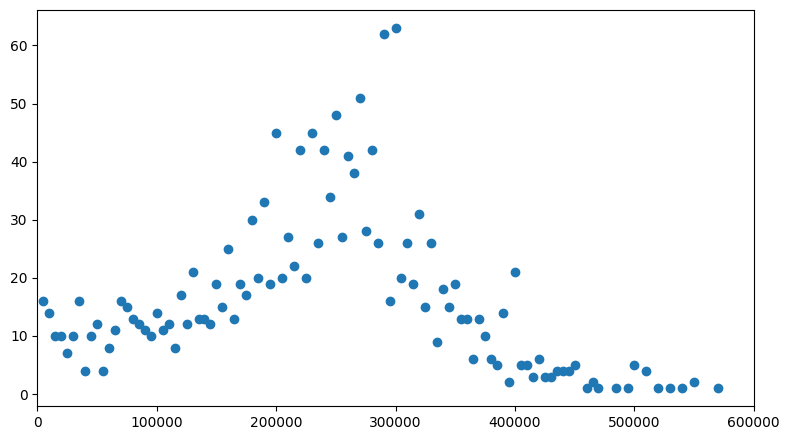

In [6]:
#+ prie to kos buvo
#  groupby(), agregacijos (mean, median), reset_index()
#  head() su groupby()

dfg = df[['R5000','K']].groupby('R5000').count().reset_index()

dfg.head()
fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(dfg['R5000'], dfg['K'])
axis.set_xlim(0, 6e5)
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()

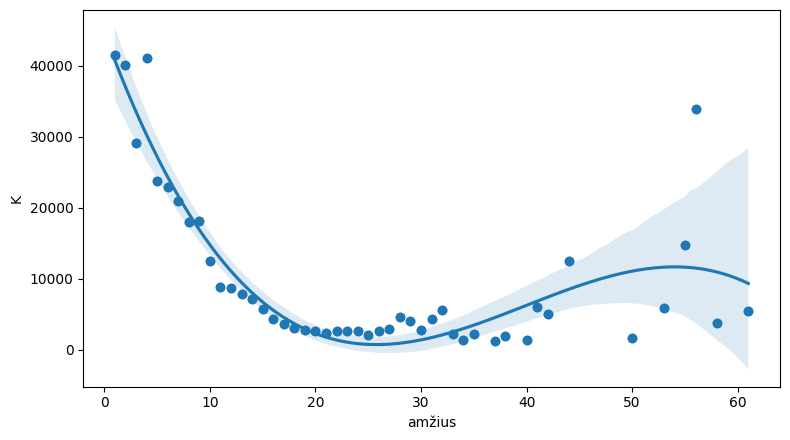

In [12]:
# Vizualizuokite, kaip nuo amžiaus priklauso automobilių kaina.
# Panaudokite seaborn regplot, kad pademonstruotumėte trendą

dfg = df[['amžius','K']].groupby('amžius').mean().reset_index()

dfg.head()
fig, axis = plt.subplots(figsize=(8,4.5))
#plotting code:

axis.scatter(dfg['amžius'], dfg['K'])
axis=sns.regplot(data=dfg, x='amžius', y='K', order=3)
#axis.set_xlim(0, 6e5)
#axis.legend(loc='best')
#axis.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()


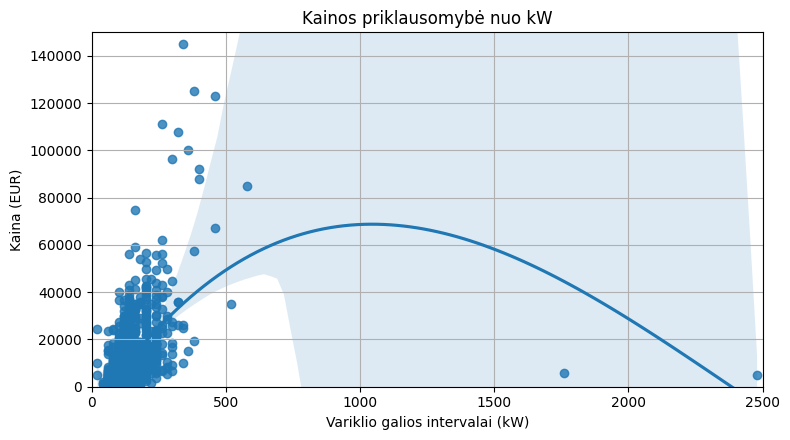

In [43]:
# Nubrezti kainos priklausomybes nuo KW . Galios intervalai po 20 kW
#kaina nevidurkinta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Apskaičiuojame variklio galią pagal intervalus po 25 kW
df['V25'] = np.ceil(df['variklis'] / 20) * 20

# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=df, x='V25', y='K', order=3, ax=axis)

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galios intervalai (kW)')
axis.set_xlim(0, 2500)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)

# Parodome grafiką
plt.tight_layout()
plt.show()


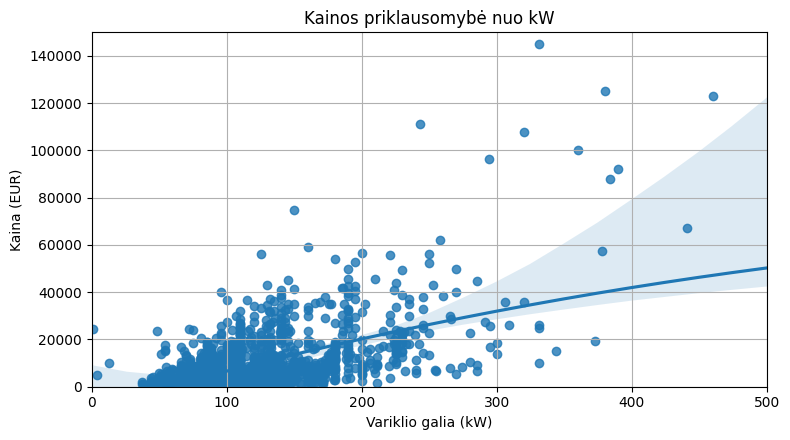

In [31]:
# Nubrezti kainos priklausomybes nuo KW . 
# Be galios intervalu, neskaiciuojant vidutines kainos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=df, x='variklis', y='K', order=3, ax=axis)

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galia (kW)')
axis.set_xlim(0, 500)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)

# Parodome grafiką
plt.tight_layout()
plt.show()

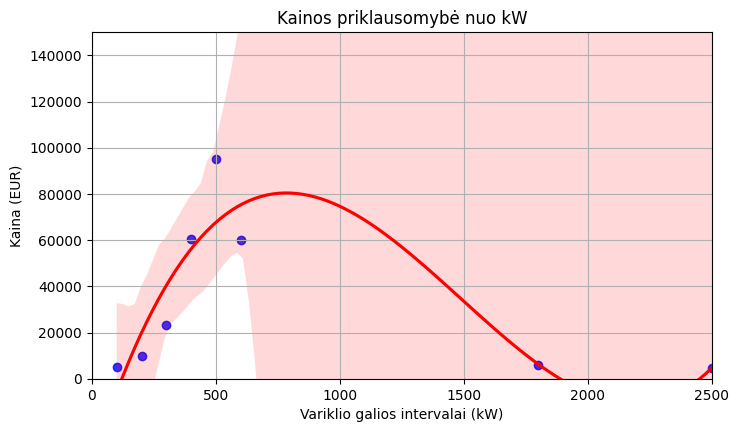

In [46]:
# Nubrezti kainos priklausomybes nuo KW . Galios intervalai po 100.
# Kaina vidurkinta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Apskaičiuojame variklio galią pagal intervalus po 25 kW
df['V25'] = np.ceil(df['variklis'] / 100) * 100
# Sukuriame grupuotą duomenų rinkinį pagal V25
dfg = df[['V25','K']].groupby('V25').mean().reset_index()
# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=dfg, x='V25', y='K', order=3, ax=axis,
            scatter_kws={'color': 'blue'},  # Taškų spalva
            line_kws={'color': 'red'})

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galios intervalai (kW)')
axis.set_xlim(0, 2500)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)


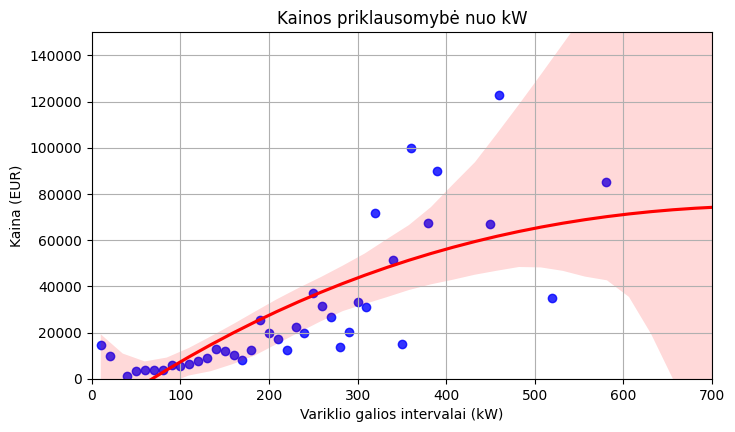

In [48]:
# Nubrezti kainos priklausomybes nuo KW . Galios intervalai po 10.
# Kaina suvidurkinta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""
# Nuskaitome duomenis į Pandas DataFrame
df = pd.read_sql_query(sql, con=DB)

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ','').replace('km','')))

# Ištraukiame kW iš variklio informacijos
df['variklis'] = df['variklis'].apply(lambda x: float(x.split('(')[1].replace('kW)', '')))

# Apskaičiuojame variklio galią pagal intervalus po 10 kW
df['V25'] = np.ceil(df['variklis'] / 10) * 10
# Sukuriame grupuotą duomenų rinkinį pagal V25
dfg = df[['V25','K']].groupby('V25').mean().reset_index()
# Sukuriame figūrą ir ašį grafikui braižyti
fig, axis = plt.subplots(figsize=(8, 4.5))

# Braižome regresijos grafiką
sns.regplot(data=dfg, x='V25', y='K', order=3, ax=axis,
            scatter_kws={'color': 'blue'},  # Taškų spalva
            line_kws={'color': 'red'})

# Papildome grafiką pavadinimais ir tinkamai sutvarkome grafiką
axis.set_title('Kainos priklausomybė nuo kW')
axis.set_xlabel('Variklio galios intervalai (kW)')
axis.set_xlim(0, 700)
axis.set_ylabel('Kaina (EUR)')
axis.set_ylim(0, 15e4)
axis.grid(True)


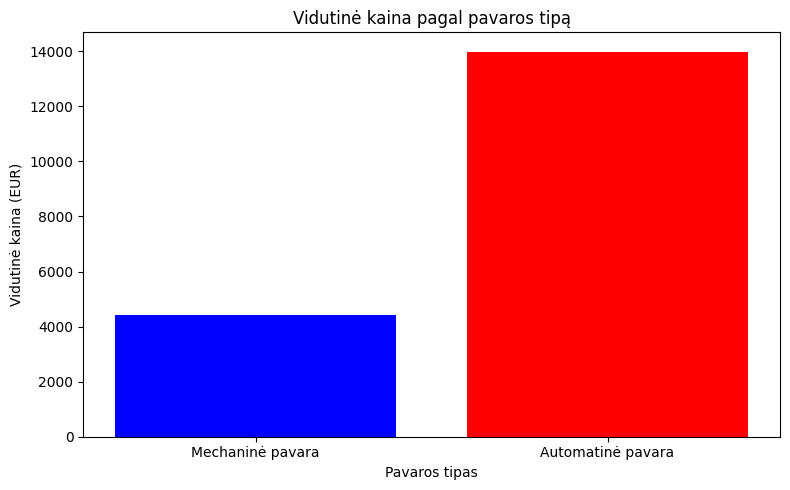

In [59]:
#kas brangiau - mechaninė ar automatinė? 
#Kiek vienetų rinkoje buvo su mechan, ir su automat?
#sql užklausa per pandas sql_query
#sql užklausa per pandas sql_query. Pridetas stulpelis su ridos intervalais 5000
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# SQL užklausa
sql = """
    WITH T1 AS (
    SELECT *, row_number() OVER (partition by id) as rc
    FROM autopliuslt
)
SELECT gamintojas, rida, price AS kaina, pagaminimo_data AS data,
       pavaros, variklis
FROM T1
WHERE rc = 1 
  AND variklis LIKE '%kW%'  -- Pašaliname įrašus be kW informacijos
ORDER BY gamintojas
"""

# Konvertuojame kainą į skaičių
df['K'] = df['kaina'].apply(lambda s: float(s.replace(' ', '').replace('km', '')))

# Apskaičiuojame vidutinę kainą mechaninėms ir automatinėms pavaroms
vid_kaina_mechanine = df[df['pavaros'] == 'Mechaninė']['K'].mean()
vid_kaina_automatine = df[df['pavaros'] == 'Automatinė']['K'].mean()

# Suskaičiuojame kiek buvo mechaninių ir automatinių transporto priemonių
kiekis_mechanine = df[df['pavaros'] == 'Mechaninė'].count()
kiekis_automatine = df[df['pavaros'] == 'Automatinė'].count()

# Išvedame vidutines kainas ir kiekius
#print(f"Vidutinė mechaninės pavaros kaina: {vid_kaina_mechanine:.2f} EUR")
#print(f"Vidutinė automatinės pavaros kaina: {vid_kaina_automatine:.2f} EUR")
#print(f"Mechaninių automobilių kiekis: {kiekis_mechanine}")
#print(f"Automatinių automobilių kiekis: {kiekis_automatine}")


# Sukuriame figūrą ir ašį grafikui braižyti
fig, ax = plt.subplots(figsize=(8, 5))

# Braižome kainos kreives
ax.bar(['Mechaninė pavara', 'Automatinė pavara'], 
       [vid_kaina_mechanine, vid_kaina_automatine], color=['blue', 'red'])

# Pridėkime pavadinimus
ax.set_title('Vidutinė kaina pagal pavaros tipą')
ax.set_xlabel('Pavaros tipas')
ax.set_ylabel('Vidutinė kaina (EUR)')

# Parodome grafiką
plt.tight_layout()
plt.show()